# Week 2: Ingest and Explore the Dataset

In [ ]:
!git clone https://github.com/zhaoyangLin1008/test.git
%cd test/Notebooks
!ls ../Data


fatal: destination path 'test' already exists and is not an empty directory.
/content/test/Notebooks
 cpi		       'stock price'			  week4_train.csv
 dgs10_m_20250826.csv   unemployment_msa_m_20250826.csv   week4_valid.csv
 dividends	        week4_test.csv


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display

In [ ]:
# Utilities — helper to drop duplicated columns by name/content
def drop_duplicate_columns(df, *, keep="first", verbose=True):
    before = df.shape[1]
    df1 = df.loc[:, ~df.columns.duplicated(keep=keep)]
    df2 = df1.loc[:, ~df1.T.duplicated(keep=keep)]
    removed = before - df2.shape[1]
    if verbose and removed > 0:
        print(f"[drop_duplicate_columns] removed {removed} duplicated columns")
    return df2


In [ ]:
# Data import
DATA_DIR = Path("../Data")
OUT_DIR  = Path("../Reports/w2_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# raw dataset Overlook
def try_infer_date_column(df):
    """Guess a date column from common names or by parsing"""
    candidates = ["date", "Date", "DATE", "observation_date", "Ex-Date", "ex_date"]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: try parsing each column
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c].head(30), errors="coerce")
            if parsed.notna().mean() > 0.6:
                return c
        except Exception:
            pass
    return None

csv_files = sorted([p for p in DATA_DIR.glob("*.csv")])
if not csv_files:
    print("[WARN] No CSV files found in /content. Please upload your data files.")
else:
    overview_rows = []
    for path in csv_files:
        df = pd.read_csv(path)

        # basic info
        nrows, ncols = df.shape
        dcol = try_infer_date_column(df)

        # check date range
        date_min, date_max = None, None
        if dcol is not None:
            dt = pd.to_datetime(df[dcol], errors="coerce")
            if dt.notna().any():
                date_min = str(dt.min().date())
                date_max = str(dt.max().date())

        num_cols = df.select_dtypes(include=[np.number]).shape[1]
        non_num_cols = ncols - num_cols

        # save a small sample for reference
        df.head(10).to_csv(OUT_DIR / f"sample__{path.stem}.csv", index=False)

        overview_rows.append({
            "filename": path.name,
            "rows": nrows,
            "cols": ncols,
            "date_col": dcol,
            "date_min": date_min,
            "date_max": date_max,
            "numeric_cols": num_cols,
            "non_numeric_cols": non_num_cols,
            "columns_preview": ", ".join(map(str, df.columns[:6]))
        })

        print(f"[CHECK] {path.name}: shape={df.shape}, "
              f"date_col={dcol}, date_range=({date_min}, {date_max})")

    # build overview table
    overview = pd.DataFrame(overview_rows).sort_values("filename").reset_index(drop=True)
    overview.to_csv(OUT_DIR / "files_overview.csv", index=False)

    # show as a table in notebook
    display(overview.head())
    print("\nOverview saved to:", OUT_DIR / "files_overview.csv")


In [ ]:
# Data basic standardization and simple engineer features
#covert data to monthly
def to_month_end(s):
    """Convert date to month-end date"""
    dt = pd.to_datetime(s, errors="coerce")
    return (dt + pd.offsets.MonthEnd(0)).dt.normalize()

#calculate the fluctuation of month to month
def level_diff(s, periods=1):
    """Month-to-month difference"""
    return s.diff(periods=periods)

#take the last price in a month
def mon_agg_last(x):
    """Get the last available value in a month"""
    return x.dropna().iloc[-1] if x.notna().any() else np.nan

#convert the stock price to monthly
def month_end_close(price_df, date_col="Date", close_col="Close"):
    tmp = price_df.copy()
    tmp[date_col] = to_month_end(tmp[date_col])
    tmp[close_col] = pd.to_numeric(tmp[close_col], errors="coerce")
    out = (tmp.groupby(date_col, as_index=False)[close_col]
              .agg(mon_agg_last)
              .rename(columns={date_col: "date", close_col: "adj_price"}))
    return out
#claculate monthly dividents
def monthly_sum_by_exdate(div_df, date_col="Ex-Date", amt_col="Amount"):
    tmp = div_df.copy()
    tmp[date_col] = to_month_end(tmp[date_col])
    tmp[amt_col] = pd.to_numeric(tmp[amt_col], errors="coerce")
    out = (tmp.groupby(date_col, as_index=False)[amt_col]
              .sum()
              .rename(columns={date_col: "date", amt_col: "dividend"}))
    return out
# divident of a year
def compute_ttm_dividend(div_monthly):
    s = div_monthly.sort_values("date")["dividend"].fillna(0.0)
    return s.rolling(window=12, min_periods=1).sum()


In [ ]:
# map the company and city
COMPANY_TO_METRO = {
    "BXP":  "Boston",
    "SLG":  "New York",
    "ELME": "Washington",
    "EQR":  "Chicago",
    "REXR": "Los Angeles",
    "TRNO": "Miami",
}

# the dividents and price of company
COMPANY_FILES = {
    "BXP":  ("stock price/bxp_prices.csv",  "dividends/bxp_dividends.csv"),
    "ELME": ("stock price/elme_prices.csv", "dividends/elme_dividends.csv"),
    "EQR":  ("stock price/eqr_prices.csv",  "dividends/eqr_dividends.csv"),
    "REXR": ("stock price/rexr_prices.csv", "dividends/rexr_dividends.csv"),
    "SLG":  ("stock price/slg_prices.csv",  "dividends/slg_dividends.csv"),
    "TRNO": ("stock price/trno_prices.csv", "dividends/trno_dividends.csv"),
}

In [ ]:
#Data cleaning
#First aspect --- Firms' data (price and dividents)
company_tables = []
for tic, (price_file, div_file) in COMPANY_FILES.items():
  #read the raw data
    px_raw = pd.read_csv(DATA_DIR / price_file)
    dv_raw = pd.read_csv(DATA_DIR / div_file)
    print(f"[{tic}] raw shapes -> prices={px_raw.shape}, dividends={dv_raw.shape}")

    # git rid of same rows
    px = px_raw.drop_duplicates().copy()
    dv = dv_raw.drop_duplicates().copy()
    # standardize time
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce")
    dv["Ex-Date"] = pd.to_datetime(dv["Ex-Date"], errors="coerce")
    #transfer numbers to folat and non numbers to NAN
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    dv["Amount"] = pd.to_numeric(dv["Amount"], errors="coerce")
    #Get rid of NANs
    px = px[px["Date"].notna() & px["Close"].notna()]
    dv = dv[dv["Ex-Date"].notna() & dv["Amount"].notna()]

    # monthly level
    px_m = month_end_close(px)
    dv_m = monthly_sum_by_exdate(dv)

    #take the same time period
    if not dv_m.empty and not px_m.empty:
     min_date = max(px_m["date"].min(), dv_m["date"].min())
     max_date = min(px_m["date"].max(), dv_m["date"].max())
     px_m = px_m[(px_m["date"] >= min_date) & (px_m["date"] <= max_date)]
     dv_m = dv_m[(dv_m["date"] >= min_date) & (dv_m["date"] <= max_date)]

    # merge and claculate TTM
    cur = (pd.merge(px_m, dv_m, on="date", how="left")
             .sort_values("date")
             .assign(dividend=lambda d: d["dividend"].fillna(0.0)))
    cur["dividend_ttm"] = compute_ttm_dividend(cur)
    cur["company"] = tic

    print(f"[{tic}] monthly rows={cur.shape[0]}, "
          f"range=({cur['date'].min().date()}, {cur['date'].max().date()})")

    company_tables.append(cur[["date","company","adj_price","dividend","dividend_ttm"]])

all_companies = pd.concat(company_tables, ignore_index=True)
all_companies.to_csv(OUT_DIR / "step2_company_monthly_all.csv", index=False)
print("[all_companies] shape:", all_companies.shape)
display(all_companies.head(20))


In [ ]:
#Data cleaning
#Second aspect --- CPI and umemployment
#CPI
CPI_FILES = {
    "Boston":      "cpi/la_cpi_boston.csv",
    "Chicago":     "cpi/la_cpi_chicago.csv",
    "Los Angeles": "cpi/la_cpi_los_angeles.csv",
    "Miami":       "cpi/la_cpi_miami.csv",
    "New York":    "cpi/la_cpi_ny.csv",
    "Washington":  "cpi/la_cpi_Washington.csv",
}
cpi_tables = []

for city, fname in CPI_FILES.items():
    path = DATA_DIR / fname
    if not path.exists():
        print(f"[WARN] Missing CPI file for {city}")
        continue

    df = pd.read_csv(path)
    if "date" in df.columns:
        dcol = "date"
    elif "DATE" in df.columns:
        dcol = "DATE"
    elif "observation_date" in df.columns:
        dcol = "observation_date"
    else:
        dcol = df.columns[0]

    vcol = "value" if "value" in df.columns else df.columns[-1]

    df = df[[dcol, vcol]].rename(columns={dcol:"date", vcol:"cpi"})
    df["date"] = to_month_end(df["date"])
    df["cpi"]  = pd.to_numeric(df["cpi"], errors="coerce")
    df = df[df["date"].notna() & df["cpi"].notna()].drop_duplicates()
    df = df.sort_values("date")

    # engineer features
    df["cpi_yoy"] = df["cpi"]/df["cpi"].shift(12) - 1
    df["cpi_mom"] = df["cpi"]/df["cpi"].shift(1)  - 1
    df["metro"]   = city

    cpi_tables.append(df[["date","metro","cpi","cpi_yoy","cpi_mom"]])

# merge all COI
cpi_all = pd.concat(cpi_tables, ignore_index=True) if cpi_tables else pd.DataFrame()
cpi_all.to_csv(OUT_DIR / "step3_cpi_all.csv", index=False)

print("CPI total shape:", cpi_all.shape)
display(cpi_all.head(10))

#Unemployment
unemp_path = DATA_DIR / "unemployment_msa_m_20250826.csv"
if not unemp_path.exists():
    print("[WARN] Unemployment file missing")
    unemp = pd.DataFrame(columns=["metro","date","unemp","unemp_mom"])
else:
    df = pd.read_csv(unemp_path)

    # standardize date and time
    df["date"]  = to_month_end(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[df["date"].notna() & df["value"].notna()].drop_duplicates()

    # metro data to the city
    df["metro"] = None
    for city in set(COMPANY_TO_METRO.values()):
        df.loc[df["city"].str.contains(city, na=False), "metro"] = city
    df = df.dropna(subset=["metro"])

    # take average to month
    unemp = (df.groupby(["metro","date"], as_index=False)["value"]
               .mean()
               .rename(columns={"value":"unemp"}))
    # month to month and year to year data
    unemp = unemp.sort_values(["metro","date"])
    unemp["unemp_mom"] = unemp.groupby("metro")["unemp"].transform(level_diff)

unemp.to_csv(OUT_DIR / "step4_unemployment_all.csv", index=False)

print("Unemployment shape:", unemp.shape)
display(unemp.head(10))


In [ ]:
#Data cleaning
#Third aspect --- 10Y Treasury
ust10_path = DATA_DIR / "dgs10_m_20250826.csv"
if not ust10_path.exists():
    warnings.warn("10Y file missing: dgs10_m_20250826.csv")
    ust10 = pd.DataFrame(columns=["date","ten_year","ten_year_mom"])
else:
    ust10 = pd.read_csv(ust10_path)
    # sequence as the date
    ust10["date"] = to_month_end(ust10["date"])
    ust10 = ust10.sort_values("date")
    # calculate month to month change
    ust10["ten_year"] = pd.to_numeric(ust10["value"], errors="coerce")
    ust10["ten_year_mom"] = ust10["ten_year"].diff(periods=1)
    # only keep the standard rows
    ust10 = ust10[["date","ten_year","ten_year_mom"]]

# save the file
ust10.to_csv(OUT_DIR / "step5_ust10.csv", index=False)
print("[ust10] shape:", ust10.shape)
if not ust10.empty:
    print(f"[ust10] range=({ust10['date'].min().date()}, {ust10['date'].max().date()})")
display(ust10.tail(10))

In [ ]:
# Final merge: all data sources into one table
# Purpose: join sources, attach metro, de-duplicate columns, quick checks, then save.

# all companies
all_companies = pd.concat(company_tables, ignore_index=True)

# name of the city
all_companies["metro"] = all_companies["company"].map(COMPANY_TO_METRO)

# CPI
df_merged = pd.merge(all_companies, cpi_all, on=["date", "metro"], how="left")
# Unemployment rate
df_merged = pd.merge(df_merged, unemp, on=["date", "metro"], how="left")
# 10Y yield
df_merged = pd.merge(df_merged, ust10, on="date", how="left")

# de-duplicate columns BEFORE export
df_merged = drop_duplicate_columns(df_merged)

# save and display
df_merged.to_csv(OUT_DIR / "final_dataset.csv", index=False)
print("final_dataset shape:", df_merged.shape)
display(df_merged.head(20))


# Week 3: Data Split & EDA START

Verify the basic quality of merged data: date formats, deduplication, and sorting.
Ensure the dataset is clean and well-organized for subsequent splitting and modeling.

In [ ]:
# Step 1: Data existence and basic validation
def drop_duplicate_columns(df):
    """Remove duplicate columns by name or by identical content"""
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.loc[:, ~df.T.duplicated()]
    return df

# Ensure the 'date' column is in datetime format and align dates to the end of the month (for easier time series segmentation)
df_merged["date"] = pd.to_datetime(df_merged["date"])
df_merged["date"] = df_merged["date"] + pd.offsets.MonthEnd(0)

# Report duplicate rows/columns BEFORE dropping
dup_rows = df_merged.duplicated(subset=["company","date"]).sum()
dup_cols = df_merged.columns.duplicated().sum()
print(f"Duplicate rows before drop: {dup_rows}, duplicate columns: {dup_cols}")

# Remove duplicate rows/columns and sort the data
df_merged = df_merged.drop_duplicates(subset=["company","date"]).sort_values(["company","date"]).reset_index(drop=True)
df_merged = drop_duplicate_columns(df_merged)

# Check data types and missing values
print("\ndata types:")
print(df_merged.dtypes)

print("\nisna:")
print(df_merged.isna().sum())

# Display the time range for each company
print("\ntime range for each company:")
time_ranges = df_merged.groupby("company")["date"].agg(["min", "max", "count"])
print(time_ranges)

# Print the first 5 rows
print("\nhead:")
print(df_merged.head())

Split the data into training, validation, and test sets based on time sequence.
Preserve the integrity of the time series to prevent leakage of future information.

In [ ]:
# Step 2: Dataset Splitting (Train / Validation / Test)

# Sort by chronological order to avoid future data leakage
df_sorted = df_merged.sort_values("date").reset_index(drop=True)

# Calculate split indices
n_total = len(df_sorted)
train_end = int(n_total * 0.7)
valid_end = int(n_total * 0.85)

# Split the dataset
train_df = df_sorted.iloc[:train_end]
valid_df = df_sorted.iloc[train_end:valid_end]
test_df  = df_sorted.iloc[valid_end:]

print("Dataset split summary:")
print(f"Total samples: {n_total}")
print(f"Training set: {train_df.shape}, Date range {train_df['date'].min().date()} → {train_df['date'].max().date()}")
print(f"Validation set: {valid_df.shape}, Date range {valid_df['date'].min().date()} → {valid_df['date'].max().date()}")
print(f"Test set: {test_df.shape}, Date range {test_df['date'].min().date()} → {test_df['date'].max().date()}")



Output descriptive statistics and missing value statistics on the training set.
The first step in EDA, helping to understand the basic distribution of the data and potential issues.

In [ ]:
# Step 3.1: Descriptive statistics and missing value check for the training set

print("Training set size:")
print(train_df.shape)

# 1. Descriptive statistics
print("\nDescriptive statistics:")
display(train_df.describe(include="all").T)

# 2. Missing value statistics
print("\nMissing value statistics:")
missing_stats = train_df.isna().sum().to_frame("missing_count")
missing_stats["missing_pct"] = (missing_stats["missing_count"] / len(train_df)) * 100
display(missing_stats)

# 3. Number of observations per company
print("\nNumber of observations per company:")
company_counts = train_df["company"].value_counts().to_frame("n_obs")
display(company_counts)

# 4. Time range check (within training set)
print("\nTime range of the training set:")
time_ranges_train = train_df.groupby("company")["date"].agg(["min","max","count"])
display(time_ranges_train)


Plot histograms and grouped boxplots for numerical variables to examine distribution characteristics and differences across companies.
Identify skewness, outliers, and variations between companies/regions.

In [ ]:
# Step 3.2: Variable distribution visualization (Training set)

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Select numerical features (excluding date and categorical variables)
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns

print("Numerical variables:", num_cols.tolist())

# 1. Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# 2. Comparison across companies/regions (using CPI as an example)
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="company", y="cpi")
plt.title("CPI distribution by company", fontsize=14)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="metro", y="unemp")
plt.title("Unemployment rate distribution by city", fontsize=14)
plt.show()


Calculate the correlation between numerical variables and plot a heatmap.
Explore linear relationships among variables to determine if multicollinearity exists.

In [ ]:
# Step 3.3: Correlation analysis (Training set)

# Select only numerical features
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns

# Compute Pearson correlation coefficients
corr_matrix = train_df[num_cols].corr(method="pearson")

print("Correlation matrix of numerical variables:")
display(corr_matrix)

# Visualize as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation heatmap (Training set)", fontsize=14)
plt.show()



# Week4: Make Data Model Ready

In [ ]:
# Step 1: Missing Value Handling

# Backup the data
df_clean = df_merged.copy()

num_cols = ["cpi", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom"]
for col in num_cols:
    df_clean[col] = (df_clean
                     .sort_values(["metro","date"])
                     .groupby("metro")[col]
                     .ffill())

medians = df_clean[num_cols].median()
df_clean[num_cols] = df_clean[num_cols].fillna(medians)

print("Missing value check: after")
print(df_clean.isna().sum())

# Save the cleaned data
df_clean.to_csv(OUT_DIR / "week4_step1_missing_cleaned.csv", index=False)
print("Cleaned data saved")


In [ ]:
# Step 2: Outlier Handling

df_outlier = df_clean.copy()

# Trimming
df_outlier["unemp"] = df_outlier["unemp"].clip(lower=0, upper=25)
df_outlier["ten_year"] = df_outlier["ten_year"].clip(lower=0, upper=15)
df_outlier["dividend_ttm"] = df_outlier["dividend_ttm"].clip(lower=0, upper=df_outlier["dividend_ttm"].quantile(0.99))

# IQR-based winsorization
def winsorize_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

for col in ["cpi_mom", "cpi_yoy", "unemp_mom", "ten_year_mom"]:
    df_outlier[col] = winsorize_iqr(df_outlier[col])

# Check again
print("Statistics after outlier handling")
print(df_outlier[["unemp","ten_year","dividend_ttm","cpi_mom","cpi_yoy","unemp_mom","ten_year_mom"]].describe().T)

# Save the results
df_outlier.to_csv(OUT_DIR / "week4_step2_outlier_cleaned.csv", index=False)
print("Outlier handling saved")


In [ ]:
# Step 3: Variable Transformation and Standardization

from sklearn.preprocessing import StandardScaler
import joblib

df_trans = df_outlier.copy()

# Log transformation
df_trans["adj_price_log"] = np.log1p(df_trans["adj_price"])
df_trans["dividend_ttm_log"] = np.log1p(df_trans["dividend_ttm"])

# Standardization
scale_cols = [
    "cpi", "cpi_yoy", "cpi_mom",
    "unemp", "unemp_mom",
    "ten_year", "ten_year_mom",
    "adj_price_log", "dividend_ttm_log"
]

scaler = StandardScaler()
df_trans_scaled = df_trans.copy()
df_trans_scaled[scale_cols] = scaler.fit_transform(df_trans[scale_cols])

# Save model
joblib.dump(scaler, OUT_DIR / "week4_step3_scaler.pkl")

# Check standardized results
print("Statistics after standardization")
print(df_trans_scaled[scale_cols].describe().T[["mean", "std"]])

# Save data
df_trans_scaled.to_csv(OUT_DIR / "week4_step3_transformed.csv", index=False)
print("variable transformation and standardization saved")


In [ ]:
# Step 4: Remove Unnecessary or Redundant Variables

df_final = df_trans_scaled.copy()

# Drop unnecessary variables
drop_cols = ["adj_price", "dividend", "dividend_ttm"]
df_final = df_final.drop(columns=drop_cols, errors="ignore")

print("Remaining variables:")
print(df_final.columns.tolist())

# Save data
df_final.to_csv(OUT_DIR / "week4_step4_feature_selected.csv", index=False)
print("saved")


In [ ]:
# Step 5: Categorical Variable Encoding
# Purpose: one-hot encode company/metro; drop duplicated columns.

df_encoded = df_final.copy()  # df_final comes from Step 4

df_encoded = pd.get_dummies(
    df_encoded,
    columns=["company", "metro"],
    drop_first=False
)

# remove any duplicated columns (by name/content)
df_encoded = drop_duplicate_columns(df_encoded)

print("One-Hot Encoding finished. Current columns:", len(df_encoded.columns))
df_encoded.to_csv(OUT_DIR / "week4_step5_encoded.csv", index=False)
print("saved")


In [ ]:
# Step 6: Bucketize / Categorize selected numerical variables
# Purpose: quantile bins for ten_year and cpi_yoy, then one-hot; drop duplicated columns.

df_bucket = df_encoded.copy()  # from Step 5

# 3-bin for ten_year
df_bucket["ten_year_bin"] = pd.qcut(
    df_bucket["ten_year"], q=3, labels=["low", "mid", "high"]
)

# 4-bin for cpi_yoy
df_bucket["cpi_yoy_bin"] = pd.qcut(
    df_bucket["cpi_yoy"], q=4, labels=["q1", "q2", "q3", "q4"]
)

# one-hot for bins
df_bucket = pd.get_dummies(
    df_bucket,
    columns=["ten_year_bin", "cpi_yoy_bin"],
    drop_first=False
)

# remove duplicated columns (defensive)
df_bucket = drop_duplicate_columns(df_bucket)

print("Bucketized and encoded columns added.")
df_bucket.to_csv(OUT_DIR / "week4_step6_bucketized.csv", index=False)
print("Bucketized dataset saved.")


In [ ]:
# Step 7: Final Check and Export
# Purpose: chronological split on the fully-processed table; export 3 sets.

# use the fully processed table (after Step 6)
df_final_model = df_bucket.copy()

# chronological split
df_final_model = df_final_model.sort_values("date").reset_index(drop=True)
n = len(df_final_model)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

train_final = df_final_model.iloc[:train_end].copy()
valid_final = df_final_model.iloc[train_end:valid_end].copy()
test_final  = df_final_model.iloc[valid_end:].copy()

# basic checks
for name, d in [("train", train_final), ("valid", valid_final), ("test", test_final)]:
    print(name, d.shape, "missing:", int(d.isna().sum().sum()), "dupe rows:", int(d.duplicated().sum()))

# export
train_final.to_csv(OUT_DIR / "week4_train.csv", index=False)
valid_final.to_csv(OUT_DIR / "week4_valid.csv", index=False)
test_final.to_csv(OUT_DIR / "week4_test.csv", index=False)
print("Final datasets saved (train/valid/test)")


# Week5: Engineer Features, Data augmentation, Dimensionality Reduction

## Engineer Features

In [ ]:
# Step 1: Construct Target Variable TSR

# copy df_encoded
df_fe = df_encoded.copy()

# make sure there is a company column
if "company" not in df_fe.columns:
    company_cols = [c for c in df_fe.columns if c.startswith("company_")]
    df_fe["company"] = df_fe[company_cols].idxmax(axis=1).str.replace("company_", "", regex=False)

# Merge original price and dividend columns
extra_cols = pd.read_csv(
    OUT_DIR / "week4_step3_transformed.csv",
    usecols=["date", "company", "adj_price", "dividend"])

# Convert the 'date' column to datetime format
extra_cols["date"] = pd.to_datetime(extra_cols["date"], errors="coerce")
df_fe["date"] = pd.to_datetime(df_fe["date"], errors="coerce")

# Merge the datasets
df_fe = pd.merge(df_fe, extra_cols, on=["date", "company"], how="left")

# Next month's price
df_fe["price_next"] = df_fe.groupby("company")["adj_price"].shift(-1)

# Next month's dividend
df_fe["div_next"] = df_fe.groupby("company")["dividend"].shift(-1)

# Calculate TSR (Total Shareholder Return)
df_fe["TSR_next"] = (
    (df_fe["price_next"] - df_fe["adj_price"]) + df_fe["div_next"]
) / df_fe["adj_price"]

# Remove the last month
df_fe = df_fe.dropna(subset=["TSR_next"]).reset_index(drop=True)

# Check
print("TSR construction completed")
print(df_fe[["date","company","adj_price","dividend","TSR_next"]].head(10))

# Save
df_fe.to_csv(OUT_DIR / "week5_step1_target.csv", index=False)
print("TSR has been saved")

In [ ]:
# Step 2: Lagged Features

df_lag = df_fe.copy()

# Define columns for generating lagged features
lag_cols = ["TSR_next", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom", "ten_year", "ten_year_mom"]

# Generate 1-period, 3-period, and 6-period lags by group
for col in lag_cols:
    for lag in [1, 3, 6]:
        df_lag[f"{col}_lag{lag}"] = df_lag.groupby("company_BXP")[col].shift(lag)

# Drop missing values
df_lag = df_lag.dropna().reset_index(drop=True)

# Check
print("Lagged feature samples")
print(df_lag[[ "date", "TSR_next", "TSR_next_lag1", "TSR_next_lag3", "TSR_next_lag6"]].head(10))

# Save
df_lag.to_csv(OUT_DIR / "week5_step2_lagged.csv", index=False)
print("Lagged features have been saved")

In [ ]:
# Step 3: Rolling Window Features

df_roll = df_lag.copy()

# Define variables for rolling window calculations
roll_cols = ["TSR_next", "cpi_mom", "unemp", "ten_year"]

# Window sizes
windows = [3, 6]

# Generate rolling mean and standard deviation
for col in roll_cols:
    for w in windows:
        df_roll[f"{col}_roll{w}_mean"] = df_roll.groupby("company_BXP")[col].transform(lambda x: x.rolling(w).mean())
        df_roll[f"{col}_roll{w}_std"]  = df_roll.groupby("company_BXP")[col].transform(lambda x: x.rolling(w).std())

# Drop rows with NA values
df_roll = df_roll.dropna().reset_index(drop=True)

# Check
print("Rolling feature samples")
print(df_roll[["date", "TSR_next", "TSR_next_roll3_mean", "TSR_next_roll3_std", "TSR_next_roll6_mean"]].head(10))

# Save results
df_roll.to_csv(OUT_DIR / "week5_step3_rolling.csv", index=False)
print("Rolling window features have been saved")

In [ ]:
# Step 4: Interaction Features

df_inter = df_roll.copy()

# 1. Interaction between inflation and unemployment
df_inter["cpi_unemp_interaction"] = df_inter["cpi_mom"] * df_inter["unemp"]

# 2. Interaction between interest rate and dividend
df_inter["rate_div_interaction"] = df_inter["ten_year"] * df_inter["dividend_ttm_log"]

# 3. Dividend yield ratio
df_inter["div_yield_ratio"] = df_inter["dividend_ttm_log"] / (df_inter["adj_price_log"] + 1e-6)

# Check results
print("Interaction feature samples")
print(df_inter[["date","cpi_unemp_interaction","rate_div_interaction","div_yield_ratio"]].head(10))

# Save
df_inter.to_csv(OUT_DIR / "week5_step4_interaction.csv", index=False)
print("Interaction features have been saved")

In [ ]:
# Step 5: Time Features

df_time = df_inter.copy()

# Extract month
df_time["month"] = pd.to_datetime(df_time["date"]).dt.month

# One-Hot Encoding
df_time = pd.get_dummies(df_time, columns=["month"], prefix="month", drop_first=False)

# Check
month_cols = [col for col in df_time.columns if col.startswith("month_")]
print("Time feature samples")
print(df_time[["date"] + month_cols].head(15))

# Save
df_time.to_csv(OUT_DIR / "week5_step5_time_features.csv", index=False)
print("Time features have been saved")

##Data augmentation

In [ ]:
#Output directory for Week 5
AUG_OUT_DIR = Path("../Reports/w5_out")
AUG_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
#1) Build a modeling dataset and compute the target variable
#Target: next-month total shareholder return (TSR)
#TSR_{t+1} = (Price_{t+1} + Dividend_{t+1}) / Price_{t} - 1
def build_modeling_dataset(df: pd.DataFrame) -> pd.DataFrame:
    required_cols = [
        "date", "company", "metro",
        "adj_price", "dividend", "dividend_ttm",
        "cpi", "cpi_yoy", "cpi_mom",
        "unemp", "unemp_mom",
        "ten_year", "ten_year_mom",
    ]
    miss = [c for c in required_cols if c not in df.columns]
    if miss:
        raise ValueError(f"Missing expected columns in df_merged: {miss}")

    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.dropna(subset=["date"]).sort_values(["company", "date"]).reset_index(drop=True)

    # Compute next-month TSR within each company
    def compute_next_tsr(g: pd.DataFrame) -> pd.Series:
        p_t   = g["adj_price"]
        p_tp1 = g["adj_price"].shift(-1)
        div_tp1 = g["dividend"].shift(-1)
        y = ((p_tp1 + div_tp1) / p_t) - 1.0
        return y

    d["tsr_next_1m"] = d.groupby("company", group_keys=False).apply(compute_next_tsr)
    d = d.dropna(subset=["tsr_next_1m"]).reset_index(drop=True)

    keep_cols = required_cols + ["tsr_next_1m"]
    base = d[keep_cols].copy()

    base.to_csv(AUG_OUT_DIR / "w5_base_modeling_dataset.csv", index=False)
    print(f"[base] saved to {AUG_OUT_DIR/'w5_base_modeling_dataset.csv'} with shape={base.shape}")
    return base


In [ ]:
#2) Noise-Jitter augmentation
#Add small Gaussian noise to numeric predictors
def _iqr_scale(x: np.ndarray) -> float:
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    if iqr <= 0:
        # fallback to std if IQR is degenerate
        return float(np.std(x)) if x.size > 1 else 0.0
    # 1.4826*IQR approximates std for normal distributions
    return 1.4826 * iqr

def augment_with_noise(
    df_base: pd.DataFrame,
    n_copies: int = 2,
    noise_frac: float = 0.08,
    seed: int = 7,
    clip_quantiles=(0.01, 0.99),
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    numeric_cols = df_base.select_dtypes(include=[np.number]).columns.tolist()
    # Do not perturb the label
    if "tsr_next_1m" in numeric_cols:
        numeric_cols.remove("tsr_next_1m")

    # Pre-compute per-column scales and quantiles
    scales = {c: _iqr_scale(df_base[c].values) for c in numeric_cols}
    qlo = df_base[numeric_cols].quantile(clip_quantiles[0])
    qhi = df_base[numeric_cols].quantile(clip_quantiles[1])

    out_list = [df_base.assign(aug_tag="original")]
    for k in range(n_copies):
        noisy = df_base.copy()
        for c in numeric_cols:
            sd = scales.get(c, 0.0)
            if not np.isfinite(sd) or sd == 0.0:
                continue
            noise = rng.normal(loc=0.0, scale=noise_frac * sd, size=len(noisy))
            noisy[c] = noisy[c].values + noise

            # clip per column to realistic range
            noisy[c] = noisy[c].clip(lower=qlo[c], upper=qhi[c])

        noisy["aug_tag"] = f"noise_{k+1}"
        out_list.append(noisy)

    aug_noise = pd.concat(out_list, ignore_index=True)
    aug_noise.to_csv(AUG_OUT_DIR / "w5_aug_noise.csv", index=False)
    print(f"[aug_noise] generated {n_copies} noisy copies. total_rows={aug_noise.shape[0]}")
    return aug_noise

In [ ]:
#3) Mixup augmentation (within-company)
def augment_with_mixup(
    df_base: pd.DataFrame,
    n_samples: int,
    alpha: float = 0.4,
    seed: int = 99,
    group_col: str = "company",
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    # Columns that should not be interpolated
    exclude_cols = ["date", "company", "metro", "aug_tag"]
    cols_to_mix = [c for c in df_base.columns if c not in exclude_cols]

    groups = df_base[group_col].unique().tolist()
    rows = []
    for _ in range(n_samples):
        g = rng.choice(groups)
        idx = df_base.index[df_base[group_col] == g].to_numpy()
        if idx.size < 2:
            continue
        i1, i2 = rng.choice(idx, size=2, replace=False)
        lam = float(rng.beta(alpha, alpha))

        row1 = df_base.loc[i1]
        row2 = df_base.loc[i2]
        mixed = row1.copy()
        # interpolate numeric and label columns
        for c in cols_to_mix:
            v1 = row1[c]
            v2 = row2[c]
            # if both numeric-like, do interpolation
            if np.issubdtype(type(v1), np.number) and np.issubdtype(type(v2), np.number):
                mixed[c] = lam * v1 + (1.0 - lam) * v2

        mixed["aug_tag"] = "mixup"
        rows.append(mixed)

    if not rows:
        raise RuntimeError("Mixup could not generate any samples (insufficient group sizes).")

    aug_mix = pd.DataFrame(rows).reset_index(drop=True)
    aug_mix.to_csv(AUG_OUT_DIR / "w5_aug_mixup.csv", index=False)
    print(f"[aug_mixup] generated {aug_mix.shape[0]} synthetic rows via mixup.")
    return aug_mix

In [ ]:
#Print the result
base = build_modeling_dataset(df_merged)

aug_noise = augment_with_noise(
    df_base=base,
    n_copies=2,        # number of noisy replicas
    noise_frac=0.08,   # noise scale
    seed=7
)

mixup_size = int(len(base) * 0.50)  # 50% of base rows
aug_mix = augment_with_mixup(
    df_base=base,
    n_samples=mixup_size,
    alpha=0.4,
    seed=99,
    group_col="company"
)

aug_all = pd.concat([aug_noise, aug_mix], ignore_index=True)
aug_all = aug_all.sample(frac=1.0, random_state=42).reset_index(drop=True)
aug_all.to_csv(AUG_OUT_DIR / "w5_aug_all.csv", index=False)

print(f"[final] saved augmented dataset to {AUG_OUT_DIR/'w5_aug_all.csv'} with shape={aug_all.shape}")
print(f"[final] NaNs in target tsr_next_1m: {aug_all['tsr_next_1m'].isna().sum()}")
print(aug_all["aug_tag"].value_counts())

## Dimensionality Reduction (Setup & Load)

In [ ]:
# load processed splits and prepare numeric matrices for DR.
TARGET_COL = "tsr_next_1m"

DATA_DIR    = Path("../Data")
REPORTS_DIR = Path("../Reports")
DIMRED_DIR  = Path("../Reports/w5_dimred")
DIMRED_DIR.mkdir(parents=True, exist_ok=True)

def split_xy(df):
    if TARGET_COL in df.columns:
        y = df[TARGET_COL].copy()
        X = df.drop(columns=[TARGET_COL])
    else:
        y = None
        X = df.copy()
    return X, y

def try_load_splits(base_dir: Path):
    tp, vp, ep = base_dir/"week4_train.csv", base_dir/"week4_valid.csv", base_dir/"week4_test.csv"
    if tp.exists() and vp.exists() and ep.exists():
        return (pd.read_csv(tp), pd.read_csv(vp), pd.read_csv(ep))
    return None

loaded = try_load_splits(DATA_DIR) or try_load_splits(REPORTS_DIR)
if loaded:
    train_df, valid_df, test_df = loaded
else:
    df_final_model = df_bucket.copy().sort_values("date").reset_index(drop=True)
    n = len(df_final_model); train_end = int(n*0.70); valid_end = int(n*0.85)
    train_df = df_final_model.iloc[:train_end].copy()
    valid_df = df_final_model.iloc[train_end:valid_end].copy()
    test_df  = df_final_model.iloc[valid_end:].copy()

X_tr_raw, y_tr = split_xy(train_df)
X_va_raw, y_va = split_xy(valid_df)
X_te_raw, y_te = split_xy(test_df)

exclude = {"date","company","metro"}
num_cols = [c for c in X_tr_raw.columns if c not in exclude and pd.api.types.is_numeric_dtype(X_tr_raw[c])]

X_tr_num = X_tr_raw[num_cols].copy()
X_va_num = X_va_raw[num_cols].copy()
X_te_num = X_te_raw[num_cols].copy()

# save with parquet if available, else CSV
def _save_df(df, stem):
    try:
        df.to_parquet(DIMRED_DIR / f"{stem}.parquet", index=False)
    except Exception:
        df.to_csv(DIMRED_DIR / f"{stem}.csv", index=False)

_save_df(X_tr_num, "X_train_num")
_save_df(X_va_num, "X_valid_num")
_save_df(X_te_num, "X_test_num")

print("Numeric shapes:", X_tr_num.shape, X_va_num.shape, X_te_num.shape)

In [ ]:
# PCA
# standardize numeric features and apply PCA; save components and models.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(X_tr_num.values)
Xva_s = scaler.transform(X_va_num.values)
Xte_s = scaler.transform(X_te_num.values)

pca_full = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full.fit(Xtr_s)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
k95 = int(np.searchsorted(cum_var, 0.95) + 1)
n_comp = int(min(50, max(2, k95)))

pca = PCA(n_components=n_comp, svd_solver="full", random_state=42)
Xtr_pca = pca.fit_transform(Xtr_s)
Xva_pca = pca.transform(Xva_s)
Xte_pca = pca.transform(Xte_s)

joblib.dump(scaler, DIMRED_DIR / "scaler.joblib")
joblib.dump(pca,    DIMRED_DIR / "pca.joblib")

# save with parquet if available, else CSV
def _save_df(df, stem):
    pqt = DIMRED_DIR / f"{stem}.parquet"
    csv = DIMRED_DIR / f"{stem}.csv"
    try:
        df.to_parquet(pqt, index=False)
    except Exception:
        df.to_csv(csv, index=False)

import pandas as pd, numpy as np
_save_df(pd.DataFrame(Xtr_pca), "X_train_pca")
_save_df(pd.DataFrame(Xva_pca), "X_valid_pca")
_save_df(pd.DataFrame(Xte_pca), "X_test_pca")

vr = pd.DataFrame({
    "component": np.arange(1, len(pca.explained_variance_ratio_)+1),
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative_variance": np.cumsum(pca.explained_variance_ratio_)
})
vr.to_csv(DIMRED_DIR / "pca_variance_report.csv", index=False)

print("PCA n_components:", n_comp)

In [ ]:
# t-SNE Embedding (train only)
# export 2D embedding for visualization/inspection.

Xtsne_in = Xtr_s
if Xtsne_in.shape[0] > 5000:
    Xtsne_in = Xtsne_in[:5000, :]

# build kwargs compatible across sklearn versions
base_kwargs = dict(n_components=2, init="pca", perplexity=30, random_state=42)
# try with learning_rate="auto"; if not supported, drop it
try:
    _ = TSNE(learning_rate="auto", **base_kwargs)
    lr_kwargs = dict(learning_rate="auto")
except TypeError:
    lr_kwargs = {}

# try max_iter first (newer sklearn), fallback to n_iter (older)
try:
    tsne = TSNE(max_iter=1000, verbose=0, **lr_kwargs, **base_kwargs)
except TypeError:
    tsne = TSNE(n_iter=1000, verbose=0, **lr_kwargs, **base_kwargs)

Z = tsne.fit_transform(Xtsne_in)

tsne_df = pd.DataFrame(Z, columns=["tsne_1","tsne_2"])
tsne_df.to_csv(DIMRED_DIR / "train_tsne2d.csv", index=False)
print("t-SNE done:", tsne_df.shape)


# Week6：Develop First modeling approach

## Model training setup

In [ ]:
import json

# Paths
BASE = Path("..")
DATA = BASE / "Data"
DOCS = BASE / "Docs"
MODELS = BASE / "Models"
MODELS.mkdir(parents=True, exist_ok=True)
DOCS.mkdir(parents=True, exist_ok=True)

# Read data
train_csv = DATA / "week4_train.csv"
valid_csv = DATA / "week4_valid.csv"
if not train_csv.exists():
    raise FileNotFoundError(f"Missing {train_csv}")
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(valid_csv) if valid_csv.exists() else None

# Target name
hint = DOCS / "target_column.txt"
TARGET_COL = hint.read_text(encoding="utf-8").strip() if hint.exists() else ""

# Align target with columns
cols = list(df_train.columns); low = [c.lower() for c in cols]
want = TARGET_COL.strip().lower()
if want and want in low:
    TARGET_COL = cols[low.index(want)]
else:
    pri = ["tsr_next_1m","tsr_1m","tsr","total_shareholder_return","return","target","y"]
    TARGET_COL = next((cols[low.index(p)] for p in pri if p in low), "") or TARGET_COL
    if not TARGET_COL:
        hits = [cols[i] for i, n in enumerate(low) if ("tsr" in n or "return" in n)]
        if len(hits) == 1:
            TARGET_COL = hits[0]
    if not TARGET_COL:
        num_all = df_train.select_dtypes(include=[np.number]).columns.tolist()
        if not num_all:
            raise ValueError("No numeric columns for fallback target")
        TARGET_COL = num_all[-1]
        print("[Warn] Fallback target ->", TARGET_COL)
# Persist target
hint.write_text(TARGET_COL, encoding="utf-8")

# Numeric features
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES = [c for c in num_cols if c != TARGET_COL]
if not FEATURES:
    raise ValueError("No numeric features found")

# Build matrices
X_train = df_train[FEATURES]
y_train = df_train[TARGET_COL].astype(float)
X_val = df_val[FEATURES] if df_val is not None else None
y_val = df_val[TARGET_COL].astype(float) if df_val is not None else None

# Save schema
schema = {
    "target": TARGET_COL,
    "features": FEATURES,
    "train_rows": int(len(X_train)),
    "val_rows": int(len(X_val)) if X_val is not None else 0,
    "train_source": "Data/week4_train.csv",
    "val_source": "Data/week4_valid.csv" if df_val is not None else ""
}
(MODELS / "training_schema.json").write_text(json.dumps(schema, indent=2), encoding="utf-8")
print("Matrices ready:", X_train.shape, y_train.shape)



## Train and save

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import time

# Use existing estimator if provided
names = ['estimator','model','clf','reg','rf','baseline']
estimator = next((globals()[k] for k in names if k in globals()), None)

# Fallback baseline if none
if estimator is None:
    estimator = RandomForestRegressor(random_state=42, n_estimators=300)

# Fit
t0 = time.time()
fitted = estimator.fit(X_train, y_train)
train_time = round(time.time() - t0, 3)

# Persist model
stamp = time.strftime("%Y%m%d-%H%M%S")
model_path = MODELS / f"baseline_{stamp}.joblib"
joblib.dump(fitted, model_path)

# Persist metadata
meta = {
    "model_file": f"Models/baseline_{stamp}.joblib",
    "algo": type(estimator).__name__,
    "params": getattr(estimator, "get_params", lambda: {})(),
    "target": TARGET_COL,
    "features": FEATURES,
    "train_rows": int(len(X_train)),
    "train_time_sec": train_time
}
(MODELS / f"baseline_{stamp}_meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Model trained ->", model_path.name)

## Hyperparameter Tuning


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint
import numpy as np

# Load datasets
train = pd.read_csv("../Reports/w2_out/week5_step5_time_features.csv")
valid = train.copy()

# Prepare features and target
target_col = "TSR_next"
feature_cols = [c for c in train.columns if c not in ["date", "company", target_col]]

X_train, y_train = train[feature_cols], train[target_col]
X_valid, y_valid = valid[feature_cols], valid[target_col]

# Define model and parameter grid
rf = RandomForestRegressor(random_state=42)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 15),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["auto", "sqrt", "log2"]
}

# Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Print best parameters and performance
print("Best Parameters Found:")
print(rf_random.best_params_)

best_model = rf_random.best_estimator_

# Evaluate on validation set
y_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²: {r2:.4f}")

# Save tuned model performance summary
results = pd.DataFrame(rf_random.cv_results_).sort_values(by="rank_test_score")
results.to_csv("../Reports/w2_out/week5_rf_tuning_results.csv", index=False)
print("Tuning results have been saved.")

In [43]:
#Model evaluation

In [55]:

import os, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

DATA = Path("test/Data")
MODELS = Path("test/Models")
REPORTS = Path("test/Reports")
EVAL_DIR = REPORTS / "w6_eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

In [56]:
#Load test data
test_path = Path("test/Reports/w2_out/week4_step5_encoded.csv")
if not test_path.exists():
    raise FileNotFoundError(f"{test_path} not found.")
print(f"[Info] Using encoded dataset: {test_path}")

df_test = pd.read_csv(test_path)

# Detect target column (contains 'tsr' or 'return')
possible_targets = [c for c in df_test.columns if "tsr" in c.lower() or "return" in c.lower()]
TARGET = possible_targets[0] if possible_targets else df_test.columns[-1]
print(f"[Info] Detected target column: {TARGET}")

# Select numeric feature columns
features = [c for c in df_test.columns if c != TARGET and pd.api.types.is_numeric_dtype(df_test[c])]
X_test = df_test[features]
y_test = df_test[TARGET].astype(float)

[Info] Using encoded dataset: test/Reports/w2_out/week4_step5_encoded.csv
[Info] Detected target column: company_TRNO


In [57]:
#Load the model
model_files = sorted(MODELS.glob("*.joblib"), key=lambda f: f.stat().st_mtime, reverse=True)
if not model_files:
    raise FileNotFoundError("No .joblib model found under /test/Models.")
model_path = model_files[0]
model = joblib.load(model_path)
print(f"[Info] Loaded model: {model_path.name}")

[Info] Loaded model: baseline_20251012-233358.joblib


In [60]:
#Evaluate performance
if hasattr(model, "feature_names_in_"):
    train_cols = model.feature_names_in_
    X_test = X_test.reindex(columns=train_cols, fill_value=0)
    print(f"[Info] Aligned test features to {len(train_cols)} columns used in training.")
else:
    print("[Warn] Model has no stored feature names; using all numeric columns as is.")

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-8))) * 100

print("\n=== Model Evaluation ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

[Info] Aligned test features to 8 columns used in training.

=== Model Evaluation ===
RMSE: 1.1334
MAE:  0.9795
R²:   -8.2013
MAPE: 7132433741.95%


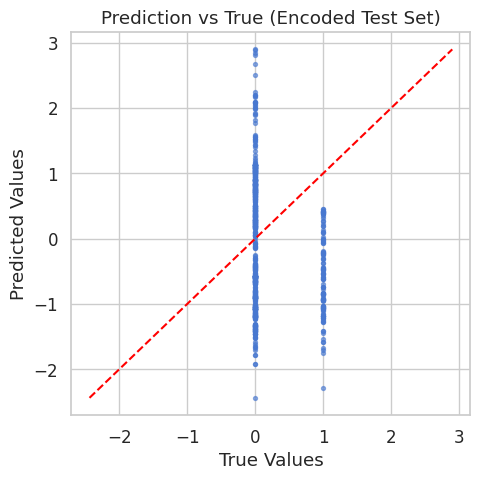

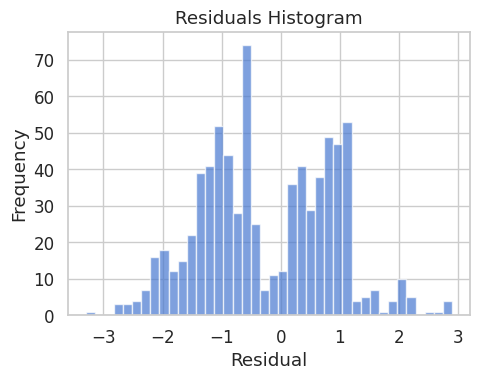

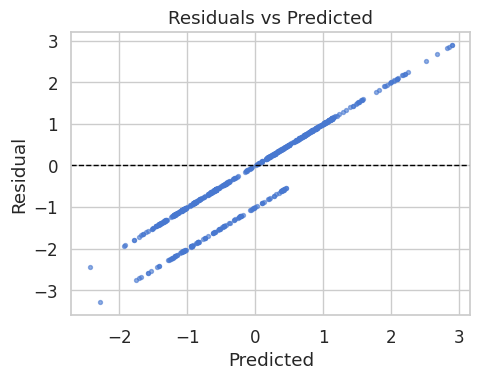

In [63]:
#visualization
# Prediction vs Actual
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], "--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs True (Encoded Test Set)")
plt.tight_layout()
plt.savefig(EVAL_DIR / "pred_vs_true.png", dpi=150)
plt.show()
plt.close()

# Residuals histogram
residuals = y_pred - y_test
plt.figure(figsize=(5,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Residuals Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(EVAL_DIR / "residual_hist.png", dpi=150)
plt.show()
plt.close()

# Residuals vs Predicted
plt.figure(figsize=(5,4))
plt.scatter(y_pred, residuals, s=8, alpha=0.6)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(EVAL_DIR / "residual_vs_pred.png", dpi=150)
plt.show()
plt.close()


In [64]:
# Save metrics and predictions
timestamp = "latest"
metrics = {
    "timestamp": timestamp,
    "model": model_path.name,
    "target": TARGET,
    "n_features": len(features),
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "MAPE": mape
}

pred_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})
pred_path = EVAL_DIR / f"predictions_{timestamp}.csv"
pred_df.to_csv(pred_path, index=False)

metrics_path = EVAL_DIR / f"metrics_{timestamp}.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("\n[Done] Evaluation completed.")
print(json.dumps(metrics, indent=2))


[Done] Evaluation completed.
{
  "timestamp": "latest",
  "model": "baseline_20251012-233358.joblib",
  "target": "company_TRNO",
  "n_features": 14,
  "RMSE": 1.133401626513858,
  "MAE": 0.9795238324537743,
  "R2": -8.201331096122317,
  "MAPE": 7132433741.953114
}
